<a href="https://colab.research.google.com/github/tanmayg/LS/blob/master/StackOverflow_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.__version__

'1.15.2'

In [0]:
import tensorflow as tf

In [0]:
PROJECT_ID = "<YOUR PROJECT ID>"

In [0]:
import sys, os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# If you are running this notebook in Colab, follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
  !pip install witwidget --quiet
  !gcloud config set project $PROJECT_ID

elif "DL_PATH" in os.environ:
  !sudo pip install tabulate --quiet

In [0]:
# Copy the data to your notebook instance
!gsutil cp 'gs://lsattentionmodelbucket/data_sample.csv' ./

Copying gs://lsattentionmodel/HT_Pros_test_data_2020Jan29_0445_sample.csv...
| [1 files][234.9 MiB/234.9 MiB]                                                
Operation completed over 1 objects/234.9 MiB.                                    
Copying gs://lsattentionmodel/HT_Pros_train_data_2020Jan29_0445_sample.csv...
/ [1 files][782.6 MiB/782.6 MiB]                                                
Operation completed over 1 objects/782.6 MiB.                                    


In [0]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import sequence
import pandas as pd
import numpy as np

def preprocess_data(datafile, batch_size, maxlen, scaler=None):
    """ Preprocessing data and getting a sequence of word indices """
    df = pd.read_csv(datafile)
    ID = list(set(list(df.data_Id)))
    mf = (len(ID)//batch_size)*batch_size
    ID = ID[:mf]
    print("\Unique ID count:", len(ID))
    df = df.set_index(['data_Id', 'feat_1'])
    df = df.iloc[df.index.get_level_values('patient_id').isin(ID)]
    
    #create the input & output sets for train data
    data_X = df.drop(['out_y1', 'out_y2', 'out_y3'],axis=1)

    #define StdScaler Scaler for input variables
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(data_X[data_X.columns])
        
    data_X[data_X.columns] = scaler.transform(data_X[data_X.columns])
    
    #define output labels
    data_Y = df[['out_y1', 'out_y2', 'out_y3']]
    data_Y = data_Y.astype(int)  

    #get the feature names
    feature_X = np.array(data_X.columns)
    feature_Y = np.array(data_Y.columns)
    
    # train data #
    data_X = [data_X.loc[patient].values for patient in ID]
    data_Y = [data_Y.loc[patient].values for patient in ID]
    
    data_X = sequence.pad_sequences(data_X, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
    data_Y = sequence.pad_sequences(data_Y, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

    #change any NAs to zero
    data_X = np.nan_to_num(data_X)
    
    return(ID, data_X, data_Y, feature_X, feature_Y, scaler)

In [0]:
batch_size=128
maxlen=5
data_ID, data_X, data_Y, feature_X, feature_Y, scaler = preprocess_data('data_sample.csv', 
                                                       batch_size=batch_size, maxlen=maxlen, scaler=None)


Dataset patient count: 6144


In [0]:
data_X.shape

(6144, 5, 1815)

In [0]:
data_X = np.nan_to_num(data_X)

In [0]:
BUFFER_SIZE = 10000
train_univariate = tf.data.Dataset.from_tensor_slices((data_X, data_Y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(batch_size).repeat()

In [0]:
#input_layer = tf.keras.layers.Input(batch_shape=(batch_size, maxlen, data_X.shape[-1]))
input_layer = tf.keras.layers.Input(data_X.shape[-2:])
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, stateful=False))(input_layer)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, stateful=False))(x)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(data_Y.shape[-1], activation='sigmoid'), name='output')(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = tf.keras.Model(outputs=output, inputs=input_layer)

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=0.0002)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1815)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 64)             473088    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 64)             24832     
_________________________________________________________________
output (TimeDistributed)     (None, 5, 25)             1625      
Total params: 499,545
Trainable params: 499,545
Non-trainable params: 0
_________________________________________________________________


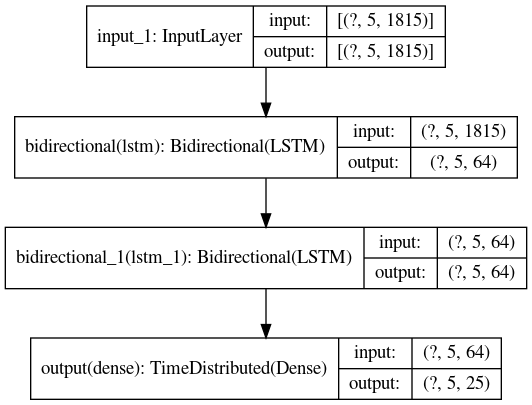

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [0]:
train_size = data_X.shape[0]
model.fit(data_X, data_Y, batch_size=batch_size, shuffle=False, epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6144 samples
Epoch 1/5
6144/6144 [==============================] - 4s 632us/sample - loss: 0.6941 - acc: 0.4996
Epoch 2/5
6144/6144 [==============================] - 2s 293us/sample - loss: 0.6940 - acc: 0.5011
Epoch 3/5
6144/6144 [==============================] - 2s 293us/sample - loss: 0.6939 - acc: 0.5025
Epoch 4/5
6144/6144 [==============================] - 2s 292us/sample - loss: 0.6938 - acc: 0.5040
Epoch 5/5
6144/6144 [==============================] - 2s 293us/sample - loss: 0.6936 - acc: 0.5055


In [0]:
## Convert our Keras model to an estimator
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir='export')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'export', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b14578390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# We need this serving input function to export our model in the next cell
serving_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    {'input_1': model.input}
)

In [0]:
BUCKET_NAME = "<YOUR BUCKET NAME>"
REGION = "us-central1"

In [0]:
export_path = keras_estimator.export_saved_model(
  'gs://' + BUCKET_NAME + '/explanations',
  serving_input_receiver_fn=serving_fn
).decode('utf-8')
print(export_path)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from export/keras/keras_model.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://lsattentionmodelbucket/explanations/temp-b'1586065104'/saved_model.pb
gs://lsattentionmodelbucket/explanations/1586065104


In [0]:
!saved_model_cli show --dir $export_path --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 1815)
        name: input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 25)
        name: output/Reshape_1:0
  Method name is: tensorflow/serving/predict


In [0]:
#Get the input_tensor_name & output_tensor_name from the command "!saved_model_cli show --dir $export_path --all" ran above.
explanation_metadata = {
    "inputs": {
      "data": {
        "input_tensor_name": "input_1:0",
        "input_baselines": [np.mean(data_X, axis=0).tolist()],
        "encoding": "bag_of_features", 
        "index_feature_mapping": feature_X.tolist()
      }
    },
    "outputs": {
      "duration": {
        "output_tensor_name": "output/Reshape_1:0"
      }
    },
  "framework": "tensorflow"
  }

In [0]:
import json
# Write the json to a local file
with open('explanation_metadata.json', 'w') as output_file:
  json.dump(explanation_metadata, output_file)

In [0]:
!gsutil cp explanation_metadata.json $export_path

Copying file://explanation_metadata.json [Content-Type=application/json]...
/ [1 files][221.7 KiB/221.7 KiB]                                                
Operation completed over 1 objects/221.7 KiB.                                    


In [0]:
MODEL = 'sample_model'

In [0]:
# Create the model if it doesn't exist yet (you only need to run this once)
!gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Created ml engine model [projects/lucid-sonar-139519/models/diag_pred_explain_stateless_0504].


In [0]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [0]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [0]:
# Make sure the model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $VERSION --model $MODEL

createTime: '2020-04-05T05:44:40Z'
deploymentUri: gs://lsattentionmodelbucket/explanations/1586065104
etag: 0yiSej983oo=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/lucid-sonar-139519/models/diag_pred_explain_stateless_0504/versions/v1
pythonVersion: '3.7'
runtimeVersion: '1.15'
state: READY


In [0]:
# Format data for prediction to our model
#prediction_json = {'input_1': data_X[0].tolist()}
prediction_json = {'input_1': data_X[:5].reshape(-1,1815).tolist()}
with open('diag-data.json', 'w') as outfile:
  json.dump(prediction_json, outfile)

In [0]:
!gcloud beta ai-platform predict --model $MODEL --json-instances='diag-data.json'

[[[0.501253188, 0.525146127, 0.518246174, 0.460763305, 0.504807234, 0.50382477, 0.505772412, 0.527180433, 0.444453567, 0.545086086, 0.462574959, 0.518344581, 0.524852037, 0.445754021, 0.467864871, 0.496275, 0.483143657, 0.52788806, 0.477311105, 0.51522857, 0.510919034, 0.482102424, 0.485438317, 0.504220724, 0.475599438], [0.495552301, 0.533200681, 0.498352617, 0.452886, 0.490913153, 0.505682, 0.501424074, 0.529344559, 0.451079637, 0.547452152, 0.450416028, 0.517447829, 0.5161677, 0.44987, 0.478985578, 0.49946475, 0.474166751, 0.532283962, 0.46969831, 0.519046485, 0.525581241, 0.471141726, 0.48349458, 0.51811856, 0.442289472], [0.497886032, 0.546987, 0.492031366, 0.45569551, 0.473153412, 0.506001174, 0.502837777, 0.540862322, 0.451522112, 0.546514928, 0.452738345, 0.520970345, 0.497458398, 0.47274977, 0.489477038, 0.505790889, 0.473407924, 0.528989553, 0.451223105, 0.526681, 0.542797, 0.473299, 0.486874223, 0.52624315, 0.417016804], [0.501761317, 0.554423273, 0.496538043, 0.462046385, 0

In [0]:
#!cat diag-data.json

In [0]:
np.array(prediction_json["input_1"]).shape

(1, 5, 1815)

In [0]:
data_X[0].shape

(5, 1815)

In [0]:
!gcloud beta ai-platform explain --model $MODEL --json-instances='diag-data.json'

{
  "error": "Explainability failed with exception: <_InactiveRpcError of RPC that terminated with:\n\tstatus = StatusCode.INVALID_ARGUMENT\n\tdetails = \"transpose expects a vector of size 4. But input(1) is a vector of size 3\n\t [[{{node bidirectional/forward_lstm_1/transpose}}]]\"\n\tdebug_error_string = \"{\"created\":\"@1586068796.692241013\",\"description\":\"Error received from peer ipv4:10.7.252.78:8500\",\"file\":\"src/core/lib/surface/call.cc\",\"file_line\":1056,\"grpc_message\":\"transpose expects a vector of size 4. But input(1) is a vector of size 3\\n\\t [[{{node bidirectional/forward_lstm_1/transpose}}]]\",\"grpc_status\":3}\"\n>"
}


In [0]:
!gcloud beta logging read --project=${PROJECT_ID}

ERROR: (gcloud) The project property must be set to a valid project ID, not the project name [-sonar-139519]
To set your project, run:

  $ gcloud config set project PROJECT_ID

or to unset it, run:

  $ gcloud config unset project


In [0]:
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='diag-data.txt'
response = json.loads(resp_obj.s)

In [0]:
response

{'error': 'Explainability failed with exception: <_InactiveRpcError of RPC that terminated with:\n\tstatus = StatusCode.INVALID_ARGUMENT\n\tdetails = "Shapes of all inputs must match: values[0].shape = [26] != values[1].shape = [1,52]\n\t [[{{node stack}}]]"\n\tdebug_error_string = "{"created":"@1585837147.415813970","description":"Error received from peer ipv4:10.59.242.41:8500","file":"src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Shapes of all inputs must match: values[0].shape = [26] != values[1].shape = [1,52]\\n\\t [[{{node stack}}]]","grpc_status":3}"\n>'}

In [0]:
model.predict(data_X[0].reshape(-1,5,1815))

array([[[0.49514586, 0.49965215, 0.51086235, 0.49489343, 0.5011939 ,
         0.49628434, 0.47265446, 0.4965824 , 0.48916355, 0.49863464,
         0.50286114, 0.5022503 , 0.50514585, 0.49308196, 0.5018075 ,
         0.49169204, 0.48702157, 0.5040773 , 0.48982868, 0.49258888,
         0.5042325 , 0.5121556 , 0.4995156 , 0.4873643 , 0.5077967 ],
        [0.50063723, 0.4966424 , 0.508897  , 0.4932428 , 0.49593756,
         0.49572882, 0.4838164 , 0.49835837, 0.48922616, 0.49465516,
         0.49862286, 0.5014685 , 0.5055968 , 0.49414843, 0.500925  ,
         0.4969879 , 0.49074098, 0.5050089 , 0.4937841 , 0.49210012,
         0.50305164, 0.50624526, 0.5017527 , 0.49211037, 0.50888413],
        [0.5006773 , 0.49530196, 0.50764984, 0.49306953, 0.49487334,
         0.49750313, 0.48865524, 0.49780306, 0.4913259 , 0.49591845,
         0.49726087, 0.50350666, 0.50319207, 0.49495783, 0.501133  ,
         0.49819806, 0.49212024, 0.50568664, 0.49443424, 0.4948849 ,
         0.5030228 , 0.50546706,

In [0]:
#Added for custom routine
MODEL_NAME = 'DiagPredMultiClass'
VERSION_NAME = 'v'+str(v_num)

In [0]:
! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION

In [0]:
#Added for custom routine
# --quiet automatically installs the beta component if it isn't already installed 
! gcloud --quiet beta ai-platform versions create $VERSION_NAME \
  --model $MODEL_NAME \
  --runtime-version 1.15 \
  --python-version 3.7 \
  --origin gs://$BUCKET_NAME/custom_prediction_routine_tutorial/model/ \
  --package-uris gs://$BUCKET_NAME/custom_prediction_routine_tutorial/my_custom_code-0.1.tar.gz \
  --prediction-class predictor.MyPredictor

In [0]:
#Added for custom routine
pip install --upgrade google-api-python-client

In [0]:
import json
# Format data for prediction to our model
prediction_json = {'input_1': np.nan_to_num(datats_X[100]).tolist()}
with open('diag-data.txt', 'w') as outfile:
  json.dump(prediction_json, outfile)

In [0]:
!gcloud beta ai-platform predict --model $MODEL_NAME --version $VERSION_NAME --json-instances='diag-data.txt'

In [0]:
datats_ID, datats_X, datats_Y, featurets_X, featurets_Y = preprocess_data_custom('HT_Pros_test_data_2020Jan29_0445_sample.csv', 
                                                       batch_size=batch_size, maxlen=maxlen, scaler=None)

In [0]:
#scale using the defined scaler
datats_X = scaler.preprocess(datats_X)

In [0]:
#Added for custom routine
#organize data in 3d format (patients, visits, features)
datats_X = [datats_X.loc[patient].values for patient in datats_ID]
datats_Y = [datats_Y.loc[patient].values for patient in datats_ID]

In [0]:
#pad or truncate rows as required
datats_X = sequence.pad_sequences(datats_X, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
datats_Y = sequence.pad_sequences(datats_Y, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

In [0]:
import googleapiclient.discovery

instances = [
  np.nan_to_num(datats_X[100]).tolist(),
  np.nan_to_num(datats_X[200]).tolist()
]

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT_ID, MODEL_NAME, VERSION_NAME)

In [0]:
response = service.projects().predict(
    name=name,
    body={'instances': instances, 'probabilities': True}
).execute()

In [0]:
response

In [0]:

if 'error' in response:
    raise RuntimeError(response['error'])
else:
  print(response['predictions'])

In [0]:
## Convert our Keras model to an estimator
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir='export')

In [0]:
# We need this serving input function to export our model in the next cell
serving_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    {'input_2': model.input}
)

In [0]:
export_path = keras_estimator.export_saved_model(
  'gs://' + BUCKET_NAME + '/explanations',
  serving_input_receiver_fn=serving_fn
).decode('utf-8')
print(export_path)

In [0]:
!saved_model_cli show --dir $export_path --all  

In [0]:
# Print the names of our tensors
print('Model input tensor: ', model.input.name)
print('Model output tensor: ', model.output.name)

In [0]:
random_baseline = np.random.rand(5, 20)

In [0]:
import pandas as pd
import numpy as np 
import json
import time

In [0]:
explanation_metadata = {
    "inputs": {
      "data": {
        "input_tensor_name": "input_2:0",
        "input_baselines": [random_baseline.tolist()]
      }
    },
    "outputs": {
      "probabilities": {
        "output_tensor_name": "output_1/Identity:0"
      }
    },
  "framework": "tensorflow"
  }

In [0]:
# Write the json to a local file
with open('explanation_metadata.json', 'w') as output_file:
  json.dump(explanation_metadata, output_file)

In [0]:
!gsutil cp explanation_metadata.json $export_path

In [0]:
MODEL = 'diag_google_ai'

In [0]:
!echo $MODEL_NAME

In [0]:
!echo $VERSION_NAME

In [0]:
# Create the model if it doesn't exist yet (you only need to run this once)
!gcloud ai-platform models create $MODEL_NAME --enable-logging --regions=us-central1

In [0]:
# Each time you create a version the name should be unique
VERSION_NAME = 'v12'

In [0]:
#original
# Create the version with gcloud
explain_method = 'sampled-shapley'
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-paths 25

In [0]:
#Added after custom predictor
# Create the version with gcloud
explain_method = 'integrated-gradients'
!gcloud beta ai-platform versions create $VERSION_NAME \
  --model $MODEL_NAME \
  --origin $export_path \
  --runtime-version 1.15 \
  --python-version 3.7 \
  --explanation-method $explain_method \
  --num-paths 25 \
  --origin gs://$BUCKET_NAME/custom_prediction_routine_tutorial/model/ \
  --package-uris gs://$BUCKET_NAME/custom_prediction_routine_tutorial/my_custom_code-0.1.tar.gz \
  --prediction-class predictor.MyPredictor \
  --machine-type n1-standard-4 \
  --framework TENSORFLOW

In [0]:
!echo $VERSION_NAME

In [0]:
!gcloud ai-platform versions describe $VERSION --model $MODEL

In [0]:
ts_in_seq[0].reshape(-1,5,20).tolist()

In [0]:
model.predict(ts_in_seq[0].reshape(-1,5,20))

In [0]:
ts_out_seq[0]

In [0]:
# Format data for prediction to our model
prediction_json = {'input_1': ts_in_seq[1].tolist()}
with open('diag-data.txt', 'w') as outfile:
  json.dump(prediction_json, outfile)

In [0]:
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='diag-data.txt'
response = json.loads(resp_obj.s)

In [0]:
!gcloud beta ai-platform predict --model $MODEL --version $VERSION --json-instances='diag-data.txt'

In [0]:
!gcloud beta ai-platform explain --help

In [0]:
!gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='diag-data.txt' --flatten

In [0]:
explanations = response['explanations'][0]['attributions_by_label'][0]

In [0]:
explanations

In [0]:
round(explanations['example_score'], 2)

In [0]:
# Prepare 10 test examples to our model for prediction
for i in range(10):
  with open('diag-data-10.txt', 'a') as outfile:
    json.dump({'input_1': ts_in_seq[i].tolist()}, outfile)
    outfile.write('\n')

In [0]:
# Make the request with gcloud
batch_explain = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='diag-data-10.txt'
attributions_resp = json.loads(batch_explain.s)

In [0]:
def sanity_check_explanations(example, mean_tgt_value=None, variance_tgt_value=None):
  passed_test = 0
  total_test = 1
  # `attributions` is a dict where keys are the feature names
  # and values are the feature attributions for each feature
  attribution_vals = [x[0] for x in example['attributions_by_label'][0]['attributions'].values()]
  baseline_score = example['attributions_by_label'][0]['baseline_score']
  sum_with_baseline = np.sum(attribution_vals) + baseline_score
  predicted_val = example['attributions_by_label'][0]['example_score']
  # Sanity check 1       
  # The prediction at the input is equal to that at the baseline.
  #  Please use a different baseline. Some suggestions are: random input, training
  #  set mean.
  if abs(predicted_val - baseline_score) <= 0.05:
    print('Warning: example score and baseline score are too close.')
    print('You might not get attributions.')
  else:
    passed_test += 1
 
  # Sanity check 2 (only for models using Integrated Gradient explanations)
  # Ideally, the sum of the integrated gradients must be equal to the difference
  # in the prediction probability at the input and baseline. Any discrepency in
  # these two values is due to the errors in approximating the integral.
  if explain_method == 'integrated-gradients':
    total_test += 1
    want_integral = predicted_val - baseline_score
    got_integral = sum(attribution_vals)
    if abs(want_integral-got_integral)/abs(want_integral) > 0.05:  
        print('Warning: Integral approximation error exceeds 5%.') 
        print('Please try increasing the number of integrated gradient steps.')
    else:
        passed_test += 1
 
  print(passed_test, ' out of ', total_test, ' sanity checks passed.')

In [0]:
for i in attributions_resp['explanations']:
  sanity_check_explanations(i)

In [0]:
# This is the number of data points we'll send to the What-if Tool
WHAT_IF_TOOL_SIZE = 100

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

def create_list(ex_dict):
  new_list = []
  for i in feature_names:
    new_list.append(ex_dict[i])
  return new_list

def example_dict_to_input(example_dict):
  return { 'input_1': create_list(example_dict) }

In [0]:
from collections import OrderedDict
wit_data = ts_in_seq.iloc[:WHAT_IF_TOOL_SIZE].copy()
wit_data['probabilities'] = test_labels[:WHAT_IF_TOOL_SIZE]
wit_data_dict = wit_data.to_dict(orient='records', into=OrderedDict)

In [0]:
df = pd.read_csv('HT_Pros_test_data_2020Jan29_0445_sample.csv')
ID = list(set(list(df.patient_id)))
mf = (len(ID)//batch_size)*batch_size
ID = ID[:mf]
print("\nDataset patient count:", len(ID))
df = df.set_index(['patient_id', 'abs_time'])
df = df.iloc[df.index.get_level_values('patient_id').isin(ID)]

#create the input & output sets for train data
X = df.drop(['hadm_id','admittime','dischtime','charttime_hr','Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y','CKDL1_y','CKDL2_y','CKDL3_y','CKDL4_y','CKDL5_y','CKDL6_y','Angina_y','Ischemic_y','StableAngina_y','VentTachy_y','Tobacco_y','CardiacArr_y','Stroke_y','BrainCncr_y', 'CervclCncr_y', 'OvarnCncr_y', 'LungCncr_y', 'BreastCncr_y', 'Alzheimer_y', 'Depression_y','clm_pymt_amt_y','cum_clm_pymt_amt_y'],axis=1)
#drop rolling mean columns
X = X[X.columns.drop(list(X.filter(regex='_amt_rm_')))]
#drop rolling std columns
X = X[X.columns.drop(list(X.filter(regex='_amt_rs_')))]
#define StdScaler Scaler for input variables
if scaler is None:
    scaler = StandardScaler()
    scaler = scaler.fit(X[X.columns])
X[X.columns] = scaler.transform(X[X.columns])
#define output labels
#Y1 = df[['Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y','CKDL1_y','CKDL2_y','CKDL3_y','CKDL4_y','CKDL5_y','CKDL6_y','Angina_y','Ischemic_y','StableAngina_y','VentTachy_y','Tobacco_y','CardiacArr_y','Stroke_y','BrainCncr_y', 'CervclCncr_y', 'OvarnCncr_y', 'LungCncr_y', 'BreastCncr_y', 'Alzheimer_y', 'Depression_y']]
Y1 = df[['Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y']]
Y1 = Y1.astype(int)

X = X.iloc[:,:20]

In [0]:
Y1.head(5)

In [0]:
from collections import OrderedDict
wit_data = X.iloc[:WHAT_IF_TOOL_SIZE].copy()
wit_data['probabilities'] = Y1.iloc[:WHAT_IF_TOOL_SIZE, 0].copy()
wit_data_dict = wit_data.to_dict(orient='records', into=OrderedDict)

In [0]:
wit_data_dict

In [0]:
feature_names = X.columns.tolist()
attributions = explanations['attributions']['data']
rows = []
for i,val in enumerate(feature_names):
  rows.append([val, X.iloc[1].tolist()[i], attributions[i]])
print(tabulate(rows,headers=['Feature name', 'Feature value', 'Attribution value']))

In [0]:
feature_names

In [0]:
config_builder = WitConfigBuilder(
    wit_data_dict
  ).set_ai_platform_model(
      PROJECT_ID,
      MODEL,
      VERSION,
      adjust_example=example_dict_to_input
  ).set_target_feature('probabilities').set_model_type('classification')
WitWidget(config_builder)